
1.   model: DeepLabV3plus

1-1 CelebAMask 이미지 라벨만들기


In [1]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

1-1-1 mask를 train valid 로 나누기

In [2]:
for path in glob('./CelebAdataset/*'):
    print(len(glob(path+'/*')))

9


In [3]:
all_mask = glob('./CelebAdataset/CelebAMask-HQ/CelebAMask_label/*')
print(len(all_mask))

30000


In [4]:
import random
random.shuffle(all_mask)

In [5]:
cnt = int(len(all_mask)*0.9)
train = all_mask[:cnt]
valid = all_mask[cnt:]
print(len(train))
print(len(valid))

27000
3000


In [10]:
import shutil
for path in tqdm(train):
    shutil.copy(path, path.replace('./CelebAdataset/CelebAMask-HQ/CelebAMask_label', './CelebAdataset/CelebAMask-HQ/train_mask'))

100%|██████████| 27000/27000 [00:01<00:00, 25374.92it/s]


In [12]:
import shutil
for path in tqdm(valid):
    shutil.copy(path, path.replace('./CelebAdataset/CelebAMask-HQ/CelebAMask_label', './CelebAdataset/CelebAMask-HQ/valid_mask'))

100%|██████████| 3000/3000 [00:00<00:00, 24830.95it/s]


1-2 image dataset/loader 정의

In [6]:
import os
import copy
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
from torchvision import transforms

In [7]:
import numpy as np

In [8]:
class CelebAMaskDataset():
    def __init__(self, img_path, label_path, transform_img, transform_label):
        self.img_path = img_path
        self.label_path = label_path
        self.transform_img = transform_img
        self.transform_label = transform_label
        self.dataset = glob(f'{label_path}/*')

    def __getitem__(self, index):
        label_path = self.dataset[index] 
        img_path = label_path.replace(self.label_path, self.img_path).replace('png', 'jpg')
        image = Image.open(img_path)
        label = Image.open(label_path)
        img, la = self.transform_img(image), self.transform_label(label)

        return img, la

    def __len__(self):
        """Return the number of images."""
        return len(self.dataset)

In [9]:
transform_Image = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor()
    ])
transform_Label = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor()
    ])

In [10]:
train_dataset = CelebAMaskDataset('./CelebAdataset/CelebAMask-HQ/CelebA-HQ-img', './CelebAdataset/CelebAMask-HQ/train_mask', transform_Image, transform_Label)
valid_dataset = CelebAMaskDataset('./CelebAdataset/CelebAMask-HQ/CelebA-HQ-img', './CelebAdataset/CelebAMask-HQ/valid_mask', transform_Image, transform_Label)

In [11]:
train_dataloaders = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
valid_dataloaders = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=8)

input image


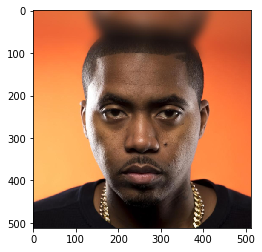

mask image


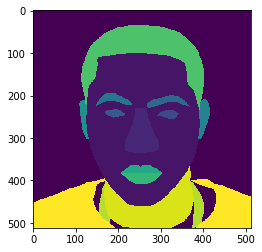

[[[ 0.]
  [ 0.]
  [ 0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]
  [ 0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]
  [ 0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]

 ...

 [[18.]
  [18.]
  [18.]
  ...
  [18.]
  [18.]
  [18.]]

 [[18.]
  [18.]
  [18.]
  ...
  [18.]
  [18.]
  [18.]]

 [[18.]
  [18.]
  [18.]
  ...
  [18.]
  [18.]
  [18.]]]


In [12]:
dataset = iter(train_dataset)
img, label = next(dataset)
img, label = img.numpy().transpose((1, 2, 0)), label.numpy().transpose((1, 2, 0))

print('input image')
plt.imshow(np.int32(img*255))
plt.show()

print('mask image')
plt.imshow(np.int32(label*255).reshape(512,512))
plt.show()
print(label*255)

1-3 model

In [13]:
import segmentation_models_pytorch as smp
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = smp.DeepLabV3Plus(encoder_name='resnet101',classes=19)
model.to(device)

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [14]:
import torch.nn.functional as F
def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()  # 4, 19, 512, 512
    nt, ht, wt = target.size()  # 4, 512, 512

    if h != ht or w != wt:
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)  #4, 19, ht, wt

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c) ## -1, c => ?, 19
    target = target.view(-1)
    loss = F.cross_entropy(input, target)
    return loss

In [15]:
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), 0.0002, [.5, .999])
scheduler=None
num_epochs=25

In [16]:
def generate_label_plain(inputs, imsize=512):
    pred_batch = []
    for input in inputs:
        input = input.view(1, 19, imsize, imsize)
        pred = np.squeeze(input.data.max(1)[1].cpu().numpy(), axis=0)
        #pred = pred.reshape((1, 512, 512))
        pred_batch.append(pred)

    pred_batch = np.array(pred_batch)
    pred_batch = torch.from_numpy(pred_batch)
            
    label_batch = []
    for p in pred_batch:
        label_batch.append(p.numpy())
                
    label_batch = np.array(label_batch)

    return label_batch

 Epoch[1/25] train : runing_Loss 0.21909: 100%|██████████| 1688/1688 [38:21<00:00,  1.36s/it]
 Epoch[1/25] valid : valid_acc 0.16568651032447815 valid_iou 0.7168405652046204: 100%|██████████| 188/188 [00:52<00:00,  3.61it/s]


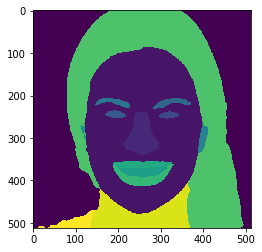

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 0 ----------


 Epoch[2/25] train : runing_Loss 0.14883: 100%|██████████| 1688/1688 [38:24<00:00,  1.37s/it]
 Epoch[2/25] valid : valid_acc 0.1733223171234131 valid_iou 0.7210716009140015: 100%|██████████| 188/188 [00:50<00:00,  3.69it/s] 


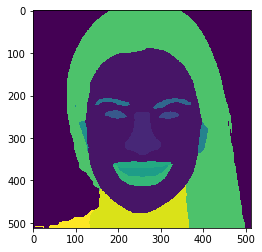

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[3/25] train : runing_Loss 0.13412: 100%|██████████| 1688/1688 [38:26<00:00,  1.37s/it]
 Epoch[3/25] valid : valid_acc 0.14012706685066223 valid_iou 0.7178490161895752: 100%|██████████| 188/188 [00:51<00:00,  3.68it/s]


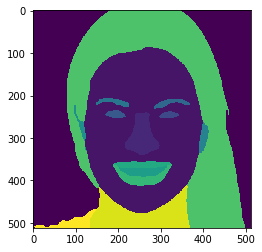

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[4/25] train : runing_Loss 0.12506: 100%|██████████| 1688/1688 [38:30<00:00,  1.37s/it]
 Epoch[4/25] valid : valid_acc 0.13788910603523255 valid_iou 0.7200928330421448: 100%|██████████| 188/188 [00:51<00:00,  3.68it/s]


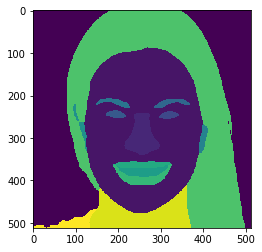

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[5/25] train : runing_Loss 0.11880: 100%|██████████| 1688/1688 [38:28<00:00,  1.37s/it]
 Epoch[5/25] valid : valid_acc 0.1496734772523244 valid_iou 0.7175697088241577: 100%|██████████| 188/188 [00:50<00:00,  3.69it/s] 


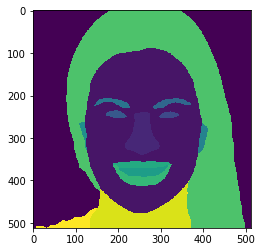

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[6/25] train : runing_Loss 0.11223: 100%|██████████| 1688/1688 [38:21<00:00,  1.36s/it]
 Epoch[6/25] valid : valid_acc 0.13256553705533344 valid_iou 0.7173116207122803: 100%|██████████| 188/188 [00:50<00:00,  3.69it/s]


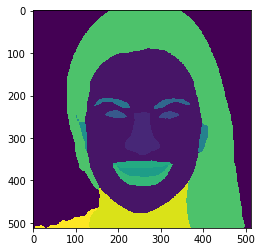

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[7/25] train : runing_Loss 0.10590: 100%|██████████| 1688/1688 [38:22<00:00,  1.36s/it]
 Epoch[7/25] valid : valid_acc 0.13316607940196992 valid_iou 0.7189326882362366: 100%|██████████| 188/188 [00:50<00:00,  3.69it/s]


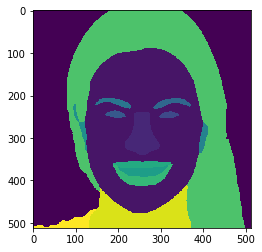

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[8/25] train : runing_Loss 0.10159: 100%|██████████| 1688/1688 [38:21<00:00,  1.36s/it]
 Epoch[8/25] valid : valid_acc 0.13343421107530593 valid_iou 0.7181241512298584: 100%|██████████| 188/188 [00:51<00:00,  3.68it/s]


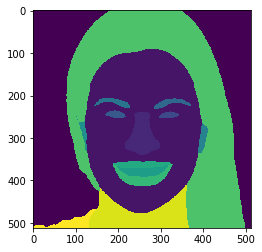

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[9/25] train : runing_Loss 0.09523: 100%|██████████| 1688/1688 [38:19<00:00,  1.36s/it]
 Epoch[9/25] valid : valid_acc 0.13738256617387135 valid_iou 0.7197237610816956: 100%|██████████| 188/188 [00:50<00:00,  3.69it/s]


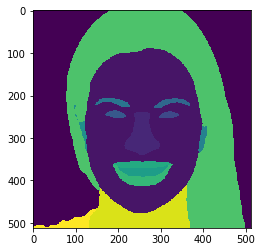

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[10/25] train : runing_Loss 0.09386: 100%|██████████| 1688/1688 [38:12<00:00,  1.36s/it]
 Epoch[10/25] valid : valid_acc 0.1335185921192169 valid_iou 0.7188759446144104: 100%|██████████| 188/188 [00:51<00:00,  3.68it/s] 


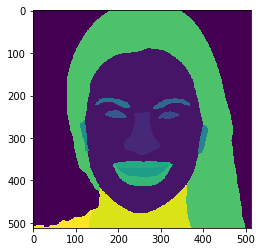

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[11/25] train : runing_Loss 0.08897: 100%|██████████| 1688/1688 [38:18<00:00,  1.36s/it]
 Epoch[11/25] valid : valid_acc 0.14074086592594784 valid_iou 0.7197549343109131: 100%|██████████| 188/188 [00:51<00:00,  3.68it/s]


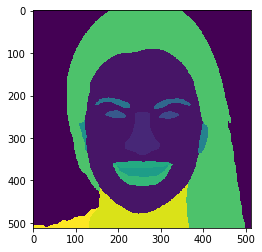

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[12/25] train : runing_Loss 0.08580: 100%|██████████| 1688/1688 [38:21<00:00,  1.36s/it]
 Epoch[12/25] valid : valid_acc 0.14071914279460906 valid_iou 0.7189894914627075: 100%|██████████| 188/188 [00:51<00:00,  3.68it/s]


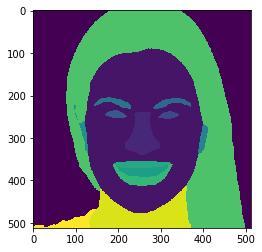

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[13/25] train : runing_Loss 0.08386: 100%|██████████| 1688/1688 [40:00<00:00,  1.42s/it]
 Epoch[13/25] valid : valid_acc 0.1515233680407206 valid_iou 0.7189671397209167: 100%|██████████| 188/188 [00:54<00:00,  3.43it/s] 


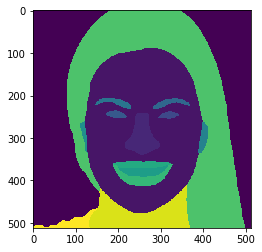

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[14/25] train : runing_Loss 0.07895: 100%|██████████| 1688/1688 [41:53<00:00,  1.49s/it]
 Epoch[14/25] valid : valid_acc 0.14728022213776906 valid_iou 0.7199654579162598: 100%|██████████| 188/188 [00:54<00:00,  3.45it/s]


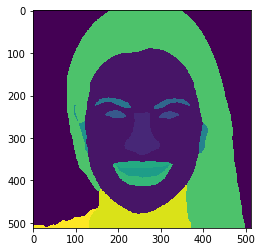

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[15/25] train : runing_Loss 0.07637: 100%|██████████| 1688/1688 [41:05<00:00,  1.46s/it]
 Epoch[15/25] valid : valid_acc 0.14811449933052062 valid_iou 0.7177178263664246: 100%|██████████| 188/188 [00:51<00:00,  3.68it/s]


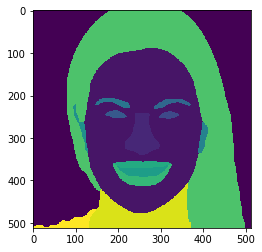

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[16/25] train : runing_Loss 0.07445: 100%|██████████| 1688/1688 [38:25<00:00,  1.37s/it]
 Epoch[16/25] valid : valid_acc 0.15121112608909607 valid_iou 0.7185465693473816: 100%|██████████| 188/188 [00:51<00:00,  3.68it/s]


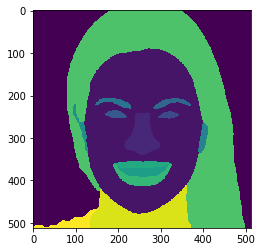

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[17/25] train : runing_Loss 0.07128: 100%|██████████| 1688/1688 [38:22<00:00,  1.36s/it]
 Epoch[17/25] valid : valid_acc 0.1538344132900238 valid_iou 0.7187936305999756: 100%|██████████| 188/188 [00:51<00:00,  3.68it/s] 


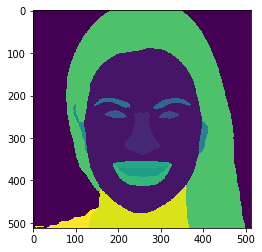

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[18/25] train : runing_Loss 0.07105: 100%|██████████| 1688/1688 [38:21<00:00,  1.36s/it]
 Epoch[18/25] valid : valid_acc 0.15463497443993887 valid_iou 0.7193610668182373: 100%|██████████| 188/188 [00:50<00:00,  3.69it/s]


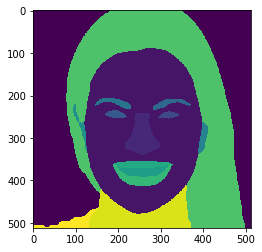

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[19/25] train : runing_Loss 0.06565: 100%|██████████| 1688/1688 [38:23<00:00,  1.36s/it]
 Epoch[19/25] valid : valid_acc 0.15596259554227193 valid_iou 0.7182452082633972: 100%|██████████| 188/188 [00:51<00:00,  3.69it/s]


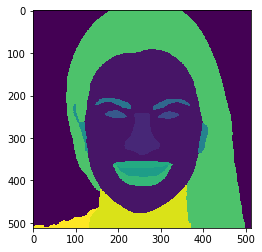

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[20/25] train : runing_Loss 0.06649: 100%|██████████| 1688/1688 [38:23<00:00,  1.36s/it]
 Epoch[20/25] valid : valid_acc 0.16056318867206573 valid_iou 0.7181292176246643: 100%|██████████| 188/188 [00:51<00:00,  3.67it/s]


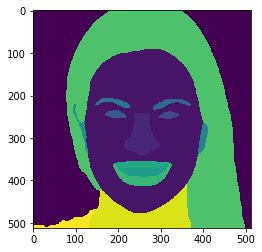

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[21/25] train : runing_Loss 0.06432: 100%|██████████| 1688/1688 [38:23<00:00,  1.36s/it]
 Epoch[21/25] valid : valid_acc 0.1623053873380025 valid_iou 0.719247043132782: 100%|██████████| 188/188 [00:51<00:00,  3.68it/s]  


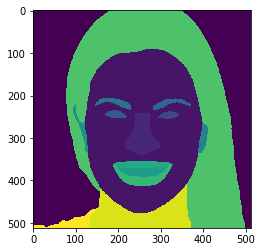

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[22/25] train : runing_Loss 0.06056: 100%|██████████| 1688/1688 [38:33<00:00,  1.37s/it]
 Epoch[22/25] valid : valid_acc 0.16608952871958416 valid_iou 0.7187014818191528: 100%|██████████| 188/188 [00:51<00:00,  3.67it/s]


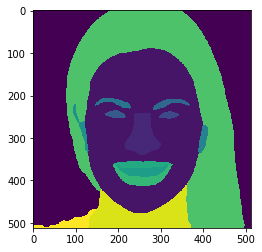

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[23/25] train : runing_Loss 0.06006: 100%|██████████| 1688/1688 [38:35<00:00,  1.37s/it]
 Epoch[23/25] valid : valid_acc 0.1653399749994278 valid_iou 0.7188968658447266: 100%|██████████| 188/188 [00:51<00:00,  3.67it/s] 


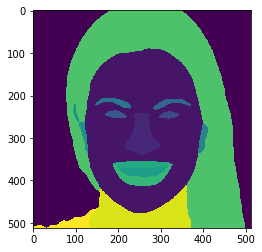

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[24/25] train : runing_Loss 0.06043: 100%|██████████| 1688/1688 [38:34<00:00,  1.37s/it]
 Epoch[24/25] valid : valid_acc 0.16848704198996226 valid_iou 0.7182011604309082: 100%|██████████| 188/188 [00:51<00:00,  3.67it/s]


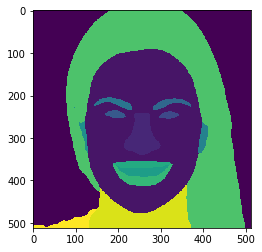

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 1 ----------


 Epoch[25/25] train : runing_Loss 0.05505: 100%|██████████| 1688/1688 [40:53<00:00,  1.45s/it]
 Epoch[25/25] valid : valid_acc 0.18028554228941598 valid_iou 0.718917965888977: 100%|██████████| 188/188 [00:54<00:00,  3.43it/s] 


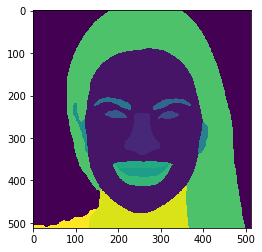

---------- best epoch : 1 ----------


In [17]:
best_model_wts = copy.deepcopy(model.state_dict())
best_iou = 0.0

for epoch in range(num_epochs):
    running_loss = 0.0
    train_corrects = 0
    train_data_cnt = 0
    train_progress_bar = tqdm(train_dataloaders) 
    for inputs, labels in train_progress_bar:
        model.train()
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        size = labels.size()
        labels[:, 0, :, :] = labels[:, 0, :, :] * 255.0
        labels_real_plain = labels[:, 0, :, :].cuda()

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels_real_plain.long())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        train_data_cnt += inputs.size(0)
        train_progress_bar.set_description(f" Epoch[{epoch+1}/{num_epochs}] train : runing_Loss {running_loss / train_data_cnt:.5f}")
        
    if scheduler:
        scheduler.step()

    valid_loss = 0
    valid_data_cnt = 0
    val_iou = 0
    valid_progress_bar = tqdm(valid_dataloaders)
    for inputs, labels in valid_progress_bar:    
        model.eval()
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad ():
            outputs = model(inputs)

        labels_predict_plain = generate_label_plain(outputs)

        intersection = torch.logical_and(labels, torch.tensor(labels_predict_plain).cuda())
        union = torch.logical_or(labels, torch.tensor(labels_predict_plain).cuda())
        val_iou += torch.sum(intersection) / torch.sum(union) * inputs.size(0)

        size = labels.size()
        labels[:, 0, :, :] = labels[:, 0, :, :] * 255.0
        labels_real_plain = labels[:, 0, :, :].cuda()
        loss = criterion(outputs, labels_real_plain.long())
        
        valid_loss += loss.item() * inputs.size(0)
        valid_data_cnt += inputs.size(0)
        valid_progress_bar.set_description(f" Epoch[{epoch+1}/{num_epochs}] valid : valid_acc {valid_loss / valid_data_cnt} valid_iou {val_iou / valid_data_cnt}")
    
    plt.imshow(labels_predict_plain[0])
    plt.show()

    epoch_iou = val_iou / valid_data_cnt
    if epoch_iou > best_iou:
        best_iou = epoch_iou
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
    print('-'*10, f"best epoch : {best_epoch}", '-'*10)